In [25]:
!pip install tensorflow
!pip install matplotlib
!pip install keras

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os


In [27]:
os.chdir('/media/lyonbach/work/Repositories/Sandbox/rim-identifier')
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" Uncomment if you want to use CPU only

In [28]:
# Limit GPU memory usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
     tf.config.experimental.set_memory_growth(gpu, True)

Here we could clean the dataset or do some other adjustments if necessary.

In [29]:
# Load data
data = tf.keras.utils.image_dataset_from_directory("dataset").map(lambda x, y: (x/255.0 , y))
iterator = data.as_numpy_iterator()

Found 1717 files belonging to 2 classes.


In [30]:
batch = iterator.next()


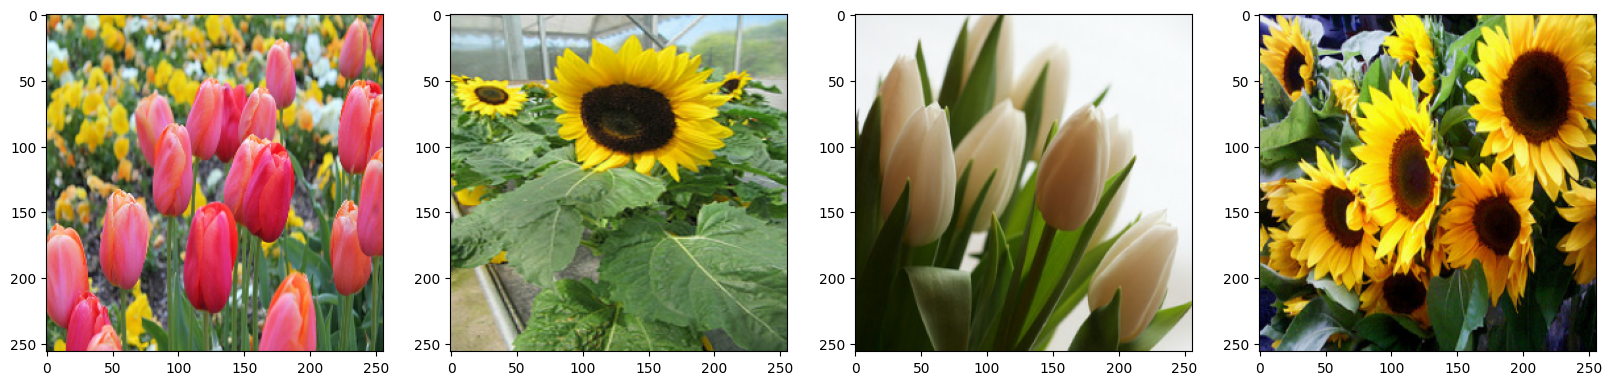

In [31]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    axs[idx].imshow(img)
    axs[idx].set_title(["sunflower", "tulip"][batch[1][idx]])


2. Split the data

In [32]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1) + 1
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(test_size + val_size).take(test_size)

3. Build The Deep Learning Model

In [33]:
assert train_size + val_size + test_size == len(data)
assert len(train) > 0
assert len(val) > 0
assert len(test) > 0

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [35]:
model = Sequential([

    Conv2D(16, 3, 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),

    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),

    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(256, activation='relu',),

    Dense(1, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

4. Train The Model

In [37]:
log_dir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
hist = model.fit(train, epochs=18, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/18


/media/lyonbach/work/Repositories/Sandbox/rim-identifier/venv/lib/python3.10/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-06 20:29:51.733153: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-06 20:29:51.860523: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-06 20:29:52.918113: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1b6c40d800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 20:29:52.918148: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2024-01-06 20:29:52.930013: I tensorflow/compil

43/43 [==============================] - 6s 61ms/step - loss: 0.4891 - accuracy: 0.5821 - val_loss: 0.3503 - val_accuracy: 0.5990
Epoch 2/18
43/43 [==============================] - 3s 60ms/step - loss: 0.3222 - accuracy: 0.5734 - val_loss: 0.2784 - val_accuracy: 0.5625
Epoch 3/18
43/43 [==============================] - 3s 60ms/step - loss: 0.2775 - accuracy: 0.5792 - val_loss: 0.3086 - val_accuracy: 0.6094
Epoch 4/18
43/43 [==============================] - 3s 60ms/step - loss: 0.2354 - accuracy: 0.5749 - val_loss: 0.2691 - val_accuracy: 0.5260
Epoch 5/18
43/43 [==============================] - 3s 59ms/step - loss: 0.1915 - accuracy: 0.5770 - val_loss: 0.2404 - val_accuracy: 0.5521
Epoch 6/18
43/43 [==============================] - 3s 60ms/step - loss: 0.1486 - accuracy: 0.5719 - val_loss: 0.1491 - val_accuracy: 0.5573
Epoch 7/18
43/43 [==============================] - 3s 59ms/step - loss: 0.1133 - accuracy: 0.5763 - val_loss: 0.1793 - val_accuracy: 0.5938
Epoch 8/18
43/43 [======

5. Plot the Performance

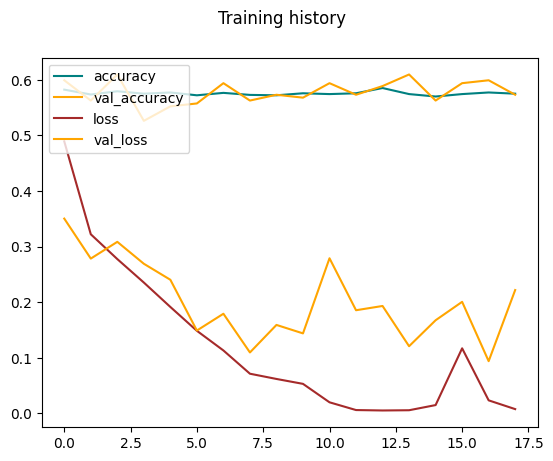

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(hist.history['loss'], color='brown', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc='upper left')
fig.suptitle('Training history')
plt.show()

6. Evaluation

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()


In [41]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 44ms/step


In [42]:
print("Precision: ", pre.result().numpy())
print("Recall: ", rec.result().numpy())
print("Accuracy: ", acc.result().numpy())

Precision:  0.6125
Recall:  1.0
Accuracy:  0.6125


7. Test

In [43]:
import cv2
# image_path = "archive/flowers/outer/960x0.webp"
# image_path = "archive/flowers/outer/F1271-1.webp"
# image_path = "dataset/sunflower/29972905_4cc537ff4b_n.jpg"
# image_path = "dataset/sunflower/151898652_b5f1c70b98_n.jpg"
# image_path = "archive/flowers/outer/360_F_575078345_LryQMyfSCcKL4e8uUYw1LJ2Re6ffn2cF.jpg"
image_path = "archive/flowers/outer/transparent-sunflower-651d0e8c7c3ce8.0350226316964030845089.jpg"
image = cv2.imread(image_path)

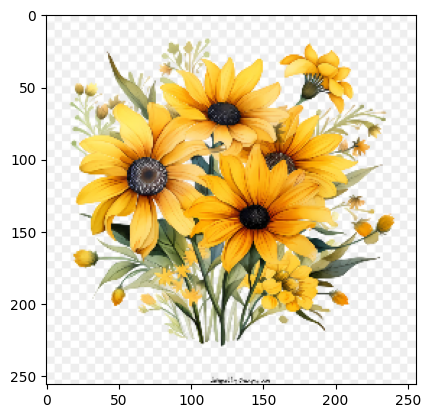

In [44]:
resized = cv2.resize(image, (256, 256))
# change color space
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

8. Prediction

In [45]:
yhat = model.predict(np.expand_dims(resized/255.0, 0))
yhat

1/1 [==============================] - 0s 199ms/step


array([[1.]], dtype=float32)